In [289]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
X = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
y=X[['Survived']] ##

In [46]:
X = X.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'Embarked'])
test = test.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'])

X['Sex'] = (X['Sex'] == 'male').astype(int) #male is 1
test['Sex'] = (test['Sex'] == 'male').astype(int)

#X.head()
#test.head()

In [47]:
#Checking for null values
X.isnull().sum()
test.isnull().sum()

for index in test.index:
    if pd.isna(test.loc[index, 'Fare']):
        test.loc[index, 'Fare'] = test['Fare'].mean()


Pclass     0
Sex        0
Age       86
SibSp      0
Parch      0
Fare       0
dtype: int64

In [49]:
#X.Age.median() #mean age is 29 median is 28 
#for missing age if they have spouse 
num_sibsp_0 = 0
total_sibsp_0 = 0

num_sibsp_1 = 0
total_sibsp_1 = 0

num_parch_0 = 0
total_parch_0 = 0

num_parch_1 = 0
total_parch_1 = 0

for age, sibsp, parch in zip(X['Age'], X['SibSp'], X['Parch']):
    if pd.isna(age):
        continue

    if sibsp == 0:
        num_sibsp_0 += 1
        total_sibsp_0 += age
    else:
        num_sibsp_1 += 1
        total_sibsp_1 += age
    
    if parch == 0:
        num_parch_0 += 1
        total_parch_0 += age
    else:
        num_parch_1 +=1
        total_parch_1 += age

avg_sibsp_0 = total_sibsp_0/num_sibsp_0
avg_sibsp_1 = total_sibsp_1/num_sibsp_1
avg_parch_0 = total_parch_0/num_parch_0
avg_parch_1 = total_parch_1/num_parch_1

l = [avg_sibsp_0,avg_sibsp_1,avg_parch_0,avg_parch_1]

print(l)

[31.39755838641189, 26.40707818930041, 32.17850287907869, 23.006062176165802]


In [50]:
#Finding which missing values are what

both0 = 0
p1s0 = 0
p0s1 = 0
both1 = 0

for age, sibsp, parch in zip(X['Age'], X['SibSp'], X['Parch']):
    if pd.isna(age):
        #print(f'parch: {parch} sibsp: {sibsp}')
        if parch == 0 and sibsp == 0:
            both0 += 1
        
        if parch > 0 and sibsp == 0:
            p1s0 += 1
        
        if parch == 0 and sibsp > 0:
            p0s1 += 1
        
        if parch > 0 and sibsp > 0:
            both1 += 1

combos = [both0, p0s1, p1s0, both1]

print(combos)
    

[133, 24, 4, 16]


In [54]:
#Replacing missing values

#Both 0's should be older. Looking at the values it should be ~31.0
#Both 1's should be younger. ~24.0
#Mixed should be median of the data = 28.0

for index in X.index:
    if pd.isna(X.loc[index, 'Age']):
        if X.loc[index, 'SibSp'] == 0 and X.loc[index, 'Parch'] == 0:
            X.loc[index, 'Age'] = 31.0
        elif X.loc[index, 'SibSp'] > 0 and X.loc[index, 'Parch'] > 0:
            X.loc[index, 'Age'] = 24.0
        else:
            X.loc[index, 'Age'] = 28.0

for index in test.index:
    if pd.isna(test.loc[index, 'Age']):
        if test.loc[index, 'SibSp'] == 0 and test.loc[index, 'Parch'] == 0:
            test.loc[index, 'Age'] = 31.0
        elif test.loc[index, 'SibSp'] > 0 and test.loc[index, 'Parch'] > 0:
            test.loc[index, 'Age'] = 24.0
        else:
            test.loc[index, 'Age'] = 28.0

print(f'Checking if that worked: \n{X.isnull().sum()}\n')

print(f'New mean and median age of the dataset: \nMean: {X['Age'].mean()} \nMedian: {X['Age'].median()}\n')

Checking if that worked: 
Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

New mean and median age of the dataset: 
Mean: 29.7375645342312 
Median: 30.0



Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

In [256]:
##Modeling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)


def XGBoostModel(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid) -> float:
    xgb1 = xgb.XGBClassifier(eval_metric='logloss')

    xgb1.fit(X_train, y_train.values.ravel())

    xgb1_pred = xgb1.predict(X_valid)

    xgb1_acc = accuracy_score(y_valid, xgb1_pred)
    return xgb1_acc

print(f'Xgboost: {XGBoostModel()}\n')

################################################

def LogisticModel(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid) -> float:
    log1 = LogisticRegression(max_iter=1000)

    log1.fit(X_train, y_train.values.ravel())

    log1_pred = log1.predict(X_valid)

    log1_acc = accuracy_score(y_valid, log1_pred)
    return log1_acc

print(f'Logistic regression: {LogisticModel()}\n')

################################################

def RandomForestModel(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid) -> float:
    randf1 = RandomForestClassifier(n_estimators=100)

    randf1.fit(X_train, y_train.values.ravel())

    randf1_pred = randf1.predict(X_valid)

    randf1_acc = accuracy_score(y_valid, randf1_pred)
    return randf1_acc

print(f'Random forest: {RandomForestModel()}\n')

################################################
def KNNModel(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid) -> float:
    knn1 = KNeighborsClassifier(n_neighbors=5)

    knn1.fit(X_train, y_train.values.ravel())

    knn1_pred = knn1.predict(X_valid)

    knn1_acc = accuracy_score(y_valid, knn1_pred)
    return knn1_acc

print(f'KNN: {KNNModel()}\n')

Xgboost: 0.8044692737430168

Logistic regression: 0.8156424581005587

Random forest: 0.776536312849162

KNN: 0.6815642458100558



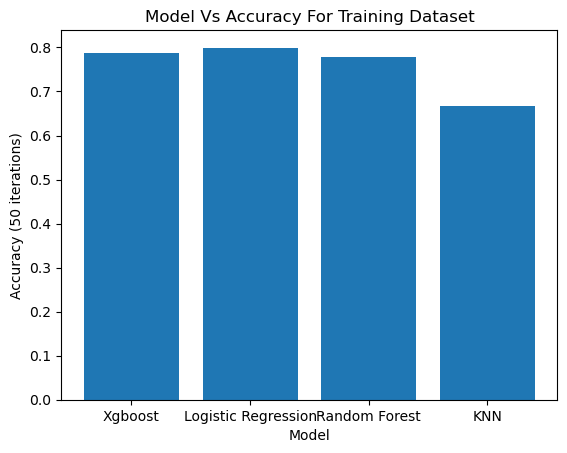

In [261]:
XGB_avg = 0
LR_avg = 0
RF_avg = 0
KNN_avg = 0

for i in range(1, 50):
    XGB_avg += XGBoostModel()
    LR_avg += LogisticModel()
    RF_avg += RandomForestModel()
    KNN_avg += KNNModel()

XGB_avg /= 50
LR_avg /= 50
RF_avg /= 50
KNN_avg /= 50

models = ['Xgboost', 'Logistic Regression', 'Random Forest', 'KNN']
accuracy_scores = [XGB_avg, LR_avg, RF_avg, KNN_avg]

plt.bar(models, accuracy_scores)
plt.title('Model Vs Accuracy For Training Dataset')
plt.xlabel('Model')
plt.ylabel('Accuracy (50 iterations)')
plt.show()

In [318]:
#Use logistic model to predict the test results

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train.values.ravel())

pred = model.predict(test)

final_df = {'PassengerId': test.index.tolist(), 'Survived': pred}

final_df = pd.DataFrame.from_dict(final_df)

final_df.set_index('PassengerId', inplace=True)

final_df.to_csv('final_predictions.csv')

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
[[-1.06611643 -2.56406694 -0.03792372 -0.33442474 -0.11454814  0.00362406]]


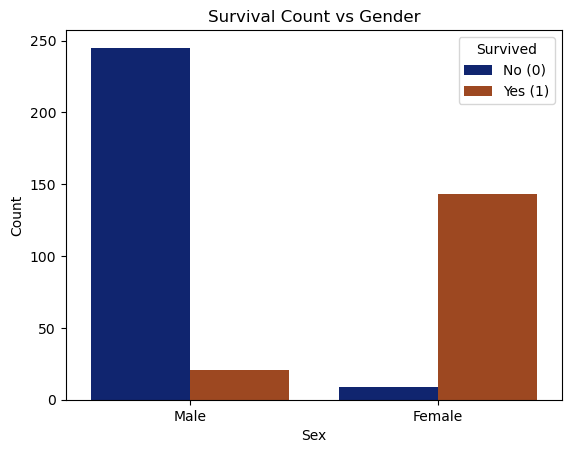

In [317]:
print(test.columns)
print(model.coef_)

#since sex and pclass were the most dominant features plot them vs survival count
age_data = {'Sex': test.Sex, 'Survived': pred}

age_data = pd.DataFrame.from_dict(age_data)

sns.countplot(x=age_data['Sex'].map({0: 'Female', 1: 'Male'}), hue=age_data['Survived'], palette="dark")

plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Survival Count vs Gender')

plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.show()

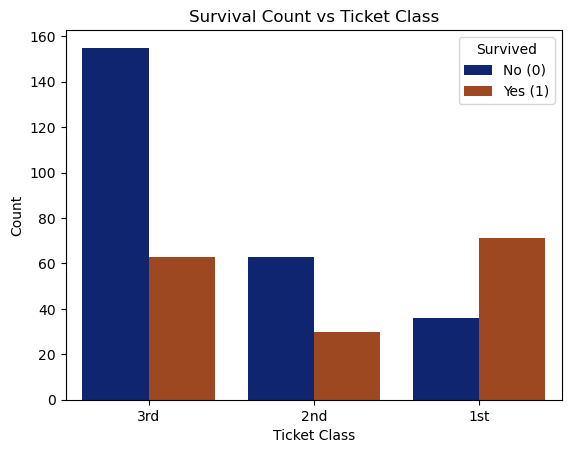

In [308]:
pclass_data = {'Pclass': test.Pclass, 'Survived': pred}

pclass_data = pd.DataFrame.from_dict(pclass_data)

sns.countplot(x=pclass_data['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'}), hue=pclass_data['Survived'], palette="dark")

plt.xlabel('Ticket Class')
plt.ylabel('Count')
plt.title('Survival Count vs Ticket Class')

plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.show()